<a href="https://colab.research.google.com/github/francotestori/aauba_01/blob/master/version_reducida_ultima_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Automático

El objetivo de este trabajo práctico es el desarrollo de una solución que permita predecir la cancelación de una reserva utilizando como dataset el archivo provisto por la catedra ***'hotel_bookins.csv'***.

In [1]:
# Cargar el archivo original de bookings
!wget https://raw.githubusercontent.com/francotestori/aauba_01/master/resources/hotel_bookings.csv

--2020-06-17 20:01:10--  https://raw.githubusercontent.com/francotestori/aauba_01/master/resources/hotel_bookings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16855599 (16M) [text/plain]
Saving to: ‘hotel_bookings.csv’

hotel_bookings.csv  100%[===================>]  16.07M  33.0MB/s    in 0.5s    

2020-06-17 20:01:11 (33.0 MB/s) - ‘hotel_bookings.csv’ saved [16855599/16855599]



In [2]:
!pip install info_gain
from info_gain import info_gain
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, datetime
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 10000)

bookings_df = pd.read_csv('hotel_bookings.csv')

## a. División en grupos y cuantificación de categorías

---

In [4]:
columnas_categoricas = [
  'hotel', 
  'is_canceled', 
  'meal', 
  'country', 
  'market_segment', 
  'distribution_channel', 
  'is_repeated_guest', 
  'deposit_type', 
  'agent', 
  'company', 
  'customer_type', 
  'reservation_status',
  'arrival_date_month'
]
df_categoricas = bookings_df[columnas_categoricas]

columnas_numericas = [
    'lead_time',  
    'stays_in_weekend_nights', 
    'stays_in_week_nights', 
    'adults', 
    'children', 
    'babies', 
    'previous_cancellations', 
    'previous_bookings_not_canceled', 
    'booking_changes', 
    'days_in_waiting_list', 
    'adr', 
    'required_car_parking_spaces', 
    'total_of_special_requests'                      
]
df_numericas = bookings_df[columnas_numericas]

columnas_ordinales = [
       'reserved_room_type', 
       'assigned_room_type'               
]
df_ordinales = bookings_df[columnas_ordinales]
df_ordinales

def get_month_number(month):
  if month == "January":
    return 1
  elif month == "February":
    return 2   
  elif month == "March":
    return 3   
  elif month == "April":
    return 4   
  elif month == "May":
    return 5   
  elif month == "June":
    return 6   
  elif month == "July":
    return 7   
  elif month == "August":
    return 8   
  elif month == "September":
    return 9   
  elif month == "October":
    return 10
  elif month == "November":
    return 11   
  elif month == "December":
    return 12
  else:
    return 0     

def checkin(year, month_str, day):
  month = get_month_number(month_str)
  return date(year, month, day)

columnas_fecha_hora = [
  'arrival_date_month', 
  'arrival_date_year',
  'arrival_date_day_of_month',   
  'reservation_status_date'               
]
df_fecha_hora = bookings_df[columnas_fecha_hora]
df_fecha_hora['checkin_date'] = df_fecha_hora.apply(
    lambda x: checkin(x['arrival_date_year'], x['arrival_date_month'], x['arrival_date_day_of_month']),
    axis=1
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## b. Valores faltantes

In [5]:
import numpy as np

df=bookings_df

for col in df.columns:
    if df[col].dtype == 'object' and col != 'country':
        df.loc[df[col].str.contains('NULL'), col] = np.nan
        df.loc[df[col].str.contains('Undefined', na=False), col] = np.nan

null_series = df.isnull().sum()

print(null_series[null_series > 0])

children                     4
meal                      1169
country                    488
market_segment               2
distribution_channel         5
agent                    16340
company                 112593
dtype: int64


In [6]:

# Haciendo un análisis inicial contamos con faltantes en los siguientes atributos:
# * **children**: Son muy pocos casos, 4. 
# * **country**: Pocos casos sería posible con alguna medida de cercanía.
# * **agent**: Relativamente grande número de faltantes, 15%.
# * **company**: Número demasiado grande de faltantes, aprox 90%.

# Sin embargo, conocemos que hay otros campos que podrian poseer valores que analogamente representan un valor nulo. 
# Por lo que para esos imputaremos las modas

# Relleno por el valor mas frecuente (moda)
bookings_df['meal'].fillna("BB", inplace = True)
bookings_df['children'].fillna(0.0, inplace = True)
bookings_df['market_segment'].fillna('Online TA', inplace = True)
bookings_df['distribution_channel'].fillna('TA/TO', inplace = True)

# Asigno un desconocido
bookings_df['country'].fillna('XXX', inplace = True)

# Utilizo un valor dummy (máscara) para la presencia de agent y company
bookings_df['agent'] = bookings_df['agent'].isnull()
bookings_df['company'] = bookings_df['company'].isnull()

In [7]:
original_nulls = bookings_df.isnull().sum()

print(original_nulls)

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

## c. Análisis de duplicados

Vamos a analizar si hay reservas duplicadas en nuestro dataframe

In [8]:
duplicated = bookings_df[bookings_df.duplicated()]

# Analizamos el porcentaje de duplicados en base a nuestra muestra
duplicated_ratio = len(duplicated)/len(bookings_df)
print(duplicated_ratio)

# Por elementos **duplicados** entendemos que todas las features de dos filas son identicos.

# Entonces sospechabamos que podría haber casos de una misma reserva que se referenciaba 2 o mas veces en nuestro dataframe.

# Sin embargo y evaluando el peso de los duplicados en nuestro dataframe (26%), entendemos simplemente que son reservas distintas pero con las mismas características.

0.26812128318954687


## c. Variables correlacionadas


In [9]:
corr = bookings_df.corr()
abs(corr.iloc[0,]).sort_values(ascending=False)

# Las cuatro variables más correlacionadas son:

# * **lead_time**                      0.293123
# * **total_of_special_requests**      0.234658
# * **required_car_parking_spaces**    0.195498
# * **booking_changes**                0.144381

is_canceled                       1.000000
lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
agent                             0.102068
company                           0.099310
is_repeated_guest                 0.084793
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005036
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

In [10]:
# PUNTO DE DUDA: CÓMO ELEGIMOS LAS CUATRO MÁS CORRELACIONADAS

# Más allá de la forma, transformamos las variables para que quede un dataset con todas variables en números

# FUNCIONES AUXILIARES
def quantify_room_type(room_type):
    if room_type == 'A':
        return 1
    elif room_type == 'B':
        return 2
    elif room_type == 'C':
        return 3
    elif room_type == 'D':
        return 4
    elif room_type == 'E':
        return 5
    elif room_type == 'F':
        return 6
    elif room_type == 'G':
        return 7
    elif room_type == 'H':
        return 8
    elif room_type == 'I':
        return 9
    elif room_type == 'K':
        return 10
    elif room_type == 'L':
        return 11
    elif room_type == 'P':
        return 12
    else:
        return 0

def room_matches(this_room, other_room):
  match = this_room.lower().replace('s/+',"") == other_room.lower().replace('s/+',"")
  if(match):
    return 1
  else:
    return 0

# CATEGÓRICAS

df_categoricas = bookings_df[columnas_categoricas]

min_dummy = len(df_categoricas)*0.005  # Mínimo de frecuencia para incluir la columna: 0.5% del total
df_categoricas['has_agent'] = bookings_df['agent'].astype(int)
df_categoricas['has_company'] = bookings_df['company'].astype(int)
dummies_cat = pd.get_dummies(
    df_categoricas, 
    columns=[
      'hotel',       
      'market_segment', 
      'meal', 
      'is_repeated_guest', 
      'deposit_type', 
      'customer_type',
      'country',
      'arrival_date_month'
    ], 
    drop_first=False
)
dummies_cat = dummies_cat.iloc[:, 8:]
corr_cat = dummies_cat[dummies_cat.columns[dummies_cat.sum()>min_dummy]]

# ORDINALES
columnas_ordinales = [
       'reserved_room_type', 
       'assigned_room_type'               
]
df_ordinales = bookings_df[columnas_ordinales]
df_ordinales['assigned_room_vl'] = df_ordinales.apply(lambda x: quantify_room_type(x['assigned_room_type']), axis=1)
df_ordinales['requested_room_vl'] = df_ordinales.apply(lambda x: quantify_room_type(x['reserved_room_type']), axis=1)
corr_cat['did_room_match'] = df_ordinales.apply(lambda x: room_matches(x['reserved_room_type'],x['assigned_room_type']), axis=1)
corr_cat['booker_room_gain'] = df_ordinales.apply(lambda x: x['assigned_room_vl'] - x['requested_room_vl'], axis=1)
corr_ord = df_ordinales[['assigned_room_vl', 'requested_room_vl']]

# NUMERICAS
columnas_numericas = [
    'lead_time',  
    'stays_in_week_nights', 
    'stays_in_weekend_nights', 
    'adults', 
    'children', 
    'babies', 
    'previous_cancellations', 
    'previous_bookings_not_canceled',     
    'days_in_waiting_list', 
    'adr', 
    'required_car_parking_spaces', 
    'total_of_special_requests'                      
]
df_numericas = bookings_df[columnas_numericas]

corr_num = df_numericas

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [11]:
# UNION
df_correlations = pd.concat([corr_num,corr_ord,corr_cat],axis=1) 
df_correlations.loc[:,'is_canceled'] = df_categoricas['is_canceled'] 

# El dataset df_correlations restante luego de nuestras transformaciones (encodings)
# termina teniendo todos sus atributos numéricos
# DEBERIAMOS UTILIZARLO EN ADELANTE PARA EL ARMADO DEL ARBOL (?)

In [12]:
corr = df_correlations[df_correlations.columns].corr()['is_canceled'][:-1] 
abs(corr).sort_values(ascending=False)
# RESTARÍA DEFINIR CÓMO ELEGIMOS LAS CUATRO MÁS CORRELACIONADAS, 
# QUE SERÁ EN FUNCIÓN DE LO QUE DEFINIMOS PARA LAS CORRELACIONES

deposit_type_Non Refund           0.481457
deposit_type_No Deposit           0.477911
country_PRT                       0.336122
lead_time                         0.293123
did_room_match                    0.247770
total_of_special_requests         0.234658
market_segment_Groups             0.221859
booker_room_gain                  0.205484
required_car_parking_spaces       0.195498
assigned_room_vl                  0.176028
market_segment_Direct             0.154390
hotel_Resort Hotel                0.136531
customer_type_Transient           0.133084
customer_type_Transient-Party     0.124135
country_FRA                       0.118254
country_GBR                       0.117106
previous_cancellations            0.110133
country_DEU                       0.107316
is_repeated_guest_0               0.084793
is_repeated_guest_1               0.084793
market_segment_Corporate          0.081667
country_ESP                       0.066981
requested_room_vl                 0.061077
adults     

In [13]:
import scipy.stats as ss
escalada = pd.DataFrame(ss.zscore(corr_cat,axis=0))
escalada.columns=corr_cat.columns
cancel=pd.DataFrame(ss.zscore(df_categoricas['is_canceled'],axis=0))


In [14]:
corr_cat_d_euclidea = pd.DataFrame(columns=['Atributo', 'Correlacion_distancia_euclidea'])

for i in range(len(escalada.columns)):
  feature= escalada.columns[i]
  coefficient = 1 - (pow(np.linalg.norm(cancel[0]-escalada.iloc[:,i]),2)/(2*len(escalada)))
  corr_cat_d_euclidea.loc[i] = [feature] + [coefficient]
corr_cat_d_euclidea.sort_values('Correlacion_distancia_euclidea',ascending=False).head()
corr_cat2=corr_cat_d_euclidea
corr_cat2

,Atributo,Correlacion_distancia_euclidea
0,hotel_Resort Hotel,-0.136531
1,market_segment_Complementary,-0.039306
2,market_segment_Corporate,-0.081667
3,market_segment_Direct,-0.154390
4,market_segment_Groups,0.221859
5,market_segment_Offline TA/TO,-0.028472
6,market_segment_Online TA,-0.006244
7,meal_BB,0.007147
8,meal_FB,0.038828
9,meal_HB,-0.019845


In [15]:
#Esto no lo ejecutamos, se podría agregar como alternativa o anexo
"""
#Defino función cramer's corrected, para categóricas
import scipy.stats as ss
import numpy as np

def cramers_corrected_stat(confusion_matrix):
    """ """calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328""""""
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
"""


"\n#Defino función cramer's corrected, para categóricas\nimport scipy.stats as ss\nimport numpy as np\n\ndef cramers_corrected_stat(confusion_matrix):\n    calculate Cramers V statistic for categorial-categorial association.\n        uses correction from Bergsma and Wicher, \n        Journal of the Korean Statistical Society 42 (2013): 323-328\n    chi2 = ss.chi2_contingency(confusion_matrix)[0]\n    n = confusion_matrix.sum().sum()\n    phi2 = chi2/n\n    r,k = confusion_matrix.shape\n    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    \n    rcorr = r - ((r-1)**2)/(n-1)\n    kcorr = k - ((k-1)**2)/(n-1)\n    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))\n"

In [16]:
#Esto no lo ejecutamos, se podría agregar como alternativa o anexo
"""
#Calculo las correlaciones para las categóricas
corr_cat2 = pd.DataFrame(columns=['Atributo', 'Cramers_V_corrected'])

for i in range(len(corr_cat.columns)):
  feature= corr_cat.columns[i]
  confusion_matrix = pd.crosstab(df_categoricas['is_canceled'],corr_cat.iloc[:,i])
  coefficient = cramers_corrected_stat(confusion_matrix)
  corr_cat2.loc[i] = [feature] + [coefficient]

corr_cat2.sort_values('Cramers_V_corrected',ascending=False)
"""


"\n#Calculo las correlaciones para las categóricas\ncorr_cat2 = pd.DataFrame(columns=['Atributo', 'Cramers_V_corrected'])\n\nfor i in range(len(corr_cat.columns)):\n  feature= corr_cat.columns[i]\n  confusion_matrix = pd.crosstab(df_categoricas['is_canceled'],corr_cat.iloc[:,i])\n  coefficient = cramers_corrected_stat(confusion_matrix)\n  corr_cat2.loc[i] = [feature] + [coefficient]\n\ncorr_cat2.sort_values('Cramers_V_corrected',ascending=False)\n"

In [17]:
#Point Biserial para las categóricas
corr_num2 = pd.DataFrame(columns=['Atributo', 'Point_Biserial'])

for i in range(len(df_numericas.columns)):
  feature2= df_numericas.columns[i]
  coefficient2 = ss.pointbiserialr(df_categoricas['is_canceled'],df_numericas.iloc[:,i])[0]
  corr_num2.loc[i] = [feature2] + [coefficient2]

corr_num2.sort_values('Point_Biserial',ascending=False)

,Atributo,Point_Biserial
0,lead_time,0.293123
6,previous_cancellations,0.110133
3,adults,0.060017
8,days_in_waiting_list,0.054186
9,adr,0.047557
1,stays_in_week_nights,0.024765
4,children,0.005036
2,stays_in_weekend_nights,-0.001791
5,babies,-0.032491
7,previous_bookings_not_canceled,-0.057358


In [18]:
#Correlaciones ordinales
corr_ord2 = pd.DataFrame(columns=['Atributo', 'Spearman'])

for i in range(len(corr_ord.columns)):
  feature3 = corr_ord.columns[i]
  coefficient3 = ss.spearmanr(df_categoricas['is_canceled'],corr_ord.iloc[:,i])[0]
  corr_ord2.loc[i] = [feature3] + [coefficient3]

corr_ord2.sort_values('Spearman',ascending=False)

,Atributo,Spearman
1,requested_room_vl,-0.067462
0,assigned_room_vl,-0.188455


In [19]:
#Unión de las correlaciones
o1 = corr_ord2 
o1.columns=['Atributo', 'Correlacion']
n1 = corr_num2 
n1.columns=['Atributo', 'Correlacion']
c1 = corr_cat2 
c1.columns=['Atributo', 'Correlacion']
correlaciones= o1.append(n1.append(c1))
correlaciones['Abs(Cor)']=abs(correlaciones['Correlacion'])
correlaciones.sort_values('Abs(Cor)', ascending=False)

,Atributo,Correlacion,Abs(Cor)
14,deposit_type_Non Refund,0.481457,0.481457
13,deposit_type_No Deposit,-0.477911,0.477911
34,country_PRT,0.336122,0.336122
0,lead_time,0.293123,0.293123
50,did_room_match,0.247770,0.247770
11,total_of_special_requests,-0.234658,0.234658
4,market_segment_Groups,0.221859,0.221859
51,booker_room_gain,-0.205484,0.205484
10,required_car_parking_spaces,-0.195498,0.195498
0,assigned_room_vl,-0.188455,0.188455


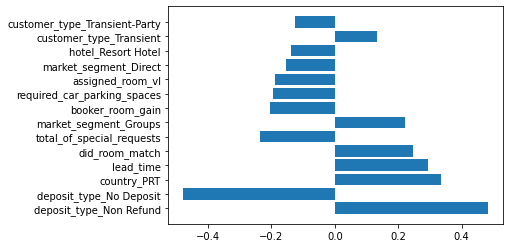

In [20]:
sortedCorr = correlaciones.sort_values('Abs(Cor)', ascending=False)[0:14]
corr = sortedCorr.Atributo
vals = sortedCorr.Correlacion
y_pos = np.arange(len(vals))
plt.barh(y_pos, vals)
plt.yticks(y_pos, corr)
plt.show()


## e. Se encuentra balanceado el set

In [21]:
# Buscamos conocer que tan balanceado está nuestro dataset
bookings_df['is_canceled'].value_counts(normalize=True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

In [22]:
df_correlations['is_canceled'].value_counts(normalize=True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

## g. Implementación Árbol de Decisión

### 1) Arbol de decisión

In [23]:
from sklearn.metrics import fbeta_score

# Con sklearn podemos dividir nuestros datos en conjuntos de entrenamiento, validación y prueba.
# Para el análisis deberiamos utilizar un DF con las variables dummies cargadas
features =  df_correlations.loc[:, df_correlations.columns != 'is_canceled'].columns
target = 'is_canceled'

# Armamos set de datos de dev (0.8) y test (0.2)
x_dev, x_test, y_dev, y_test = train_test_split(
    df_correlations[features].values, 
    df_correlations[target].values, 
    test_size=0.2, 
    random_state=42,
    stratify=df_correlations[target].values
)                           

n_seeds = 50
accs = []
precisions = []
recalls = []
f1s = []
f1s_two = []

for seed in range(n_seeds):
  # Tree Classifier
  arbol_sklearn = DecisionTreeClassifier(max_depth=len(df_correlations.columns)-1)

  # División train-validation
  # x_dev y y_dev son el 80% de mi partición anterior
  # x_train y y_train el 80% de esta partición (0.64)
  # x_val_ y y_val el 20% de esta partición (0.16)
  x_train, x_val, y_train, y_val = train_test_split(
      x_dev, 
      y_dev, 
      test_size=0.2, 
      random_state=seed,
      stratify=y_dev
  ) 

  # Entrenamos al arbol
  arbol_sklearn.fit(x_train,y_train)

  # Ejecutamos nuestra predicción
  y_pred_val = arbol_sklearn.predict(x_val)

  # Medimos (accuracy, precision, recall y f-scores) de nuestra predicción
  accs.append(
      accuracy_score(y_val,y_pred_val)
  )
  precisions.append(
      precision_score(y_val,y_pred_val)
  )
  recalls.append(
      recall_score(y_val,y_pred_val)
  )
  f1s.append(
      f1_score(y_val,y_pred_val)
  )
  f1s_two.append(
      fbeta_score(y_val, y_pred_val, beta=2)
  )

metric_labels = ['Accuracy']*len(accs) + ['Precision']*len(precisions) + ['Recall']*len(recalls) + ['F1 Score']*len(f1s) + ['F2 Score']*len(f1s_two)
all_metrics = accs + precisions + recalls + f1s + f1s_two

wanted_metric_labels = ['Precision']*len(precisions) + ['Recall']*len(recalls) + ['F2 Score']*len(f1s_two)
wanted_metrics = precisions + recalls + f1s_two


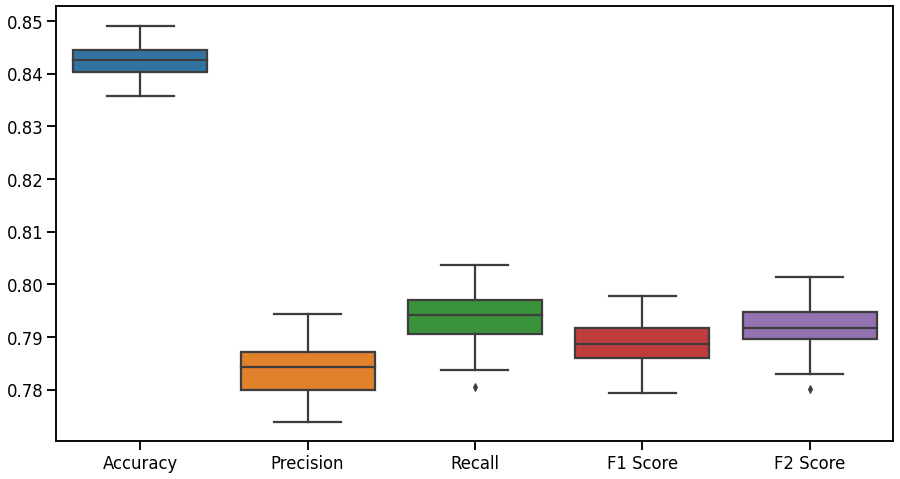

In [24]:
# Boxplots de Métricas
sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(metric_labels,all_metrics)

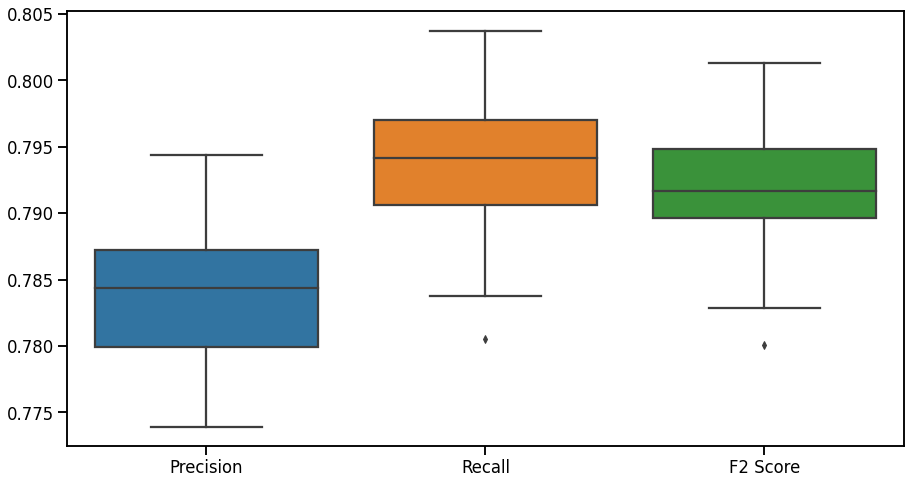

In [25]:
# Boxplots de Métricas Buscadas
sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(wanted_metric_labels,wanted_metrics)

### 2) K-fold cross validation

In [26]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import numpy as np

kfold_accs = []
kfold_precisions = []
kfold_recalls = []
kfold_f1s = []
kfold_f1s_two = []

kfoldcv = StratifiedKFold(n_splits=50)

for train_index, test_index in kfoldcv.split(x_dev, y_dev):
  x_train, x_val = x_dev[train_index], x_dev[test_index]
  y_train, y_val = y_dev[train_index], y_dev[test_index]

  # Tree Classifier
  kfold_tree = DecisionTreeClassifier(max_depth=len(df_correlations.columns)-1)

  # Entrenamos al arbol
  kfold_tree.fit(x_train,y_train)

  # Ejecutamos nuestra predicción
  y_pred_val = kfold_tree.predict(x_val)

  # Medimos (accuracy, precision, recall y f-scores) de nuestra predicción
  kfold_accs.append(
      accuracy_score(y_val,y_pred_val)
  )
  kfold_precisions.append(
      precision_score(y_val,y_pred_val)
  )
  kfold_recalls.append(
      recall_score(y_val,y_pred_val)
  )
  kfold_f1s.append(
      f1_score(y_val,y_pred_val)
  )
  kfold_f1s_two.append(
      fbeta_score(y_val, y_pred_val, beta=2)
  )

kfold_metric_labels = ['Accuracy']*len(kfold_accs) + ['Precision']*len(kfold_precisions) + ['Recall']*len(kfold_recalls) + ['F1 Score']*len(kfold_f1s) + ['F2 Score']*len(kfold_f1s_two)
kfold_all_metrics = kfold_accs + kfold_precisions + kfold_recalls + kfold_f1s + kfold_f1s_two

kfold_wanted_metric_labels = ['Precision']*len(kfold_precisions) + ['Recall']*len(kfold_recalls) + ['F2 Score']*len(kfold_f1s_two)
kfold_wanted_metrics = kfold_precisions + kfold_recalls + kfold_f1s_two


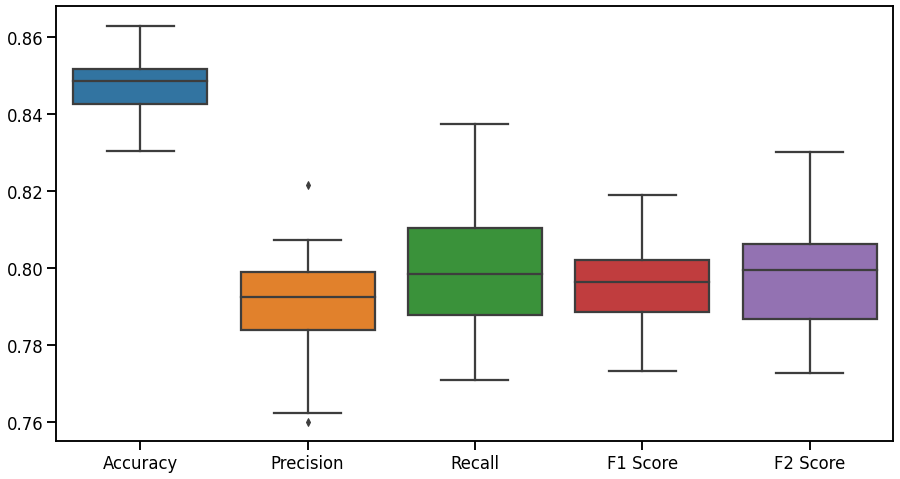

In [27]:
# Boxplots de Métricas
sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(kfold_metric_labels,kfold_all_metrics)

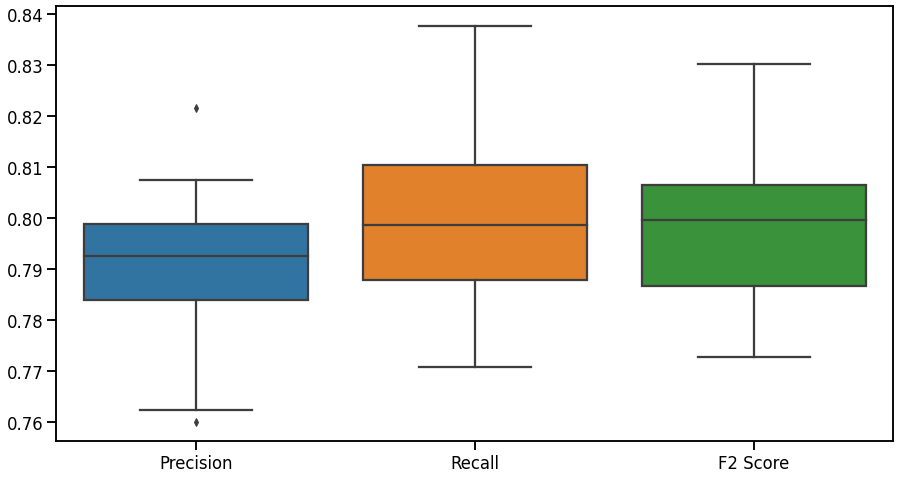

In [28]:
# Boxplots de Métricas Buscadas
sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(kfold_wanted_metric_labels,kfold_wanted_metrics)

## h. Graficar Best Tree


In [29]:
best_tree = None
best_score = None

for train_index, test_index in kfoldcv.split(x_dev, y_dev):
  x_train, x_val = x_dev[train_index], x_dev[test_index]
  y_train, y_val = y_dev[train_index], y_dev[test_index]

  # Tree Classifier
  kfold_tree = DecisionTreeClassifier(max_depth=len(df_correlations.columns)-1)

  # Entrenamos al arbol
  kfold_tree.fit(x_train,y_train)

  # Ejecutamos nuestra predicción
  y_pred_val = kfold_tree.predict(x_val)

  f2score = fbeta_score(y_val, y_pred_val, beta=2)

  if best_score is None or best_score < f2score:
    best_score = f2score
    best_tree = kfold_tree



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


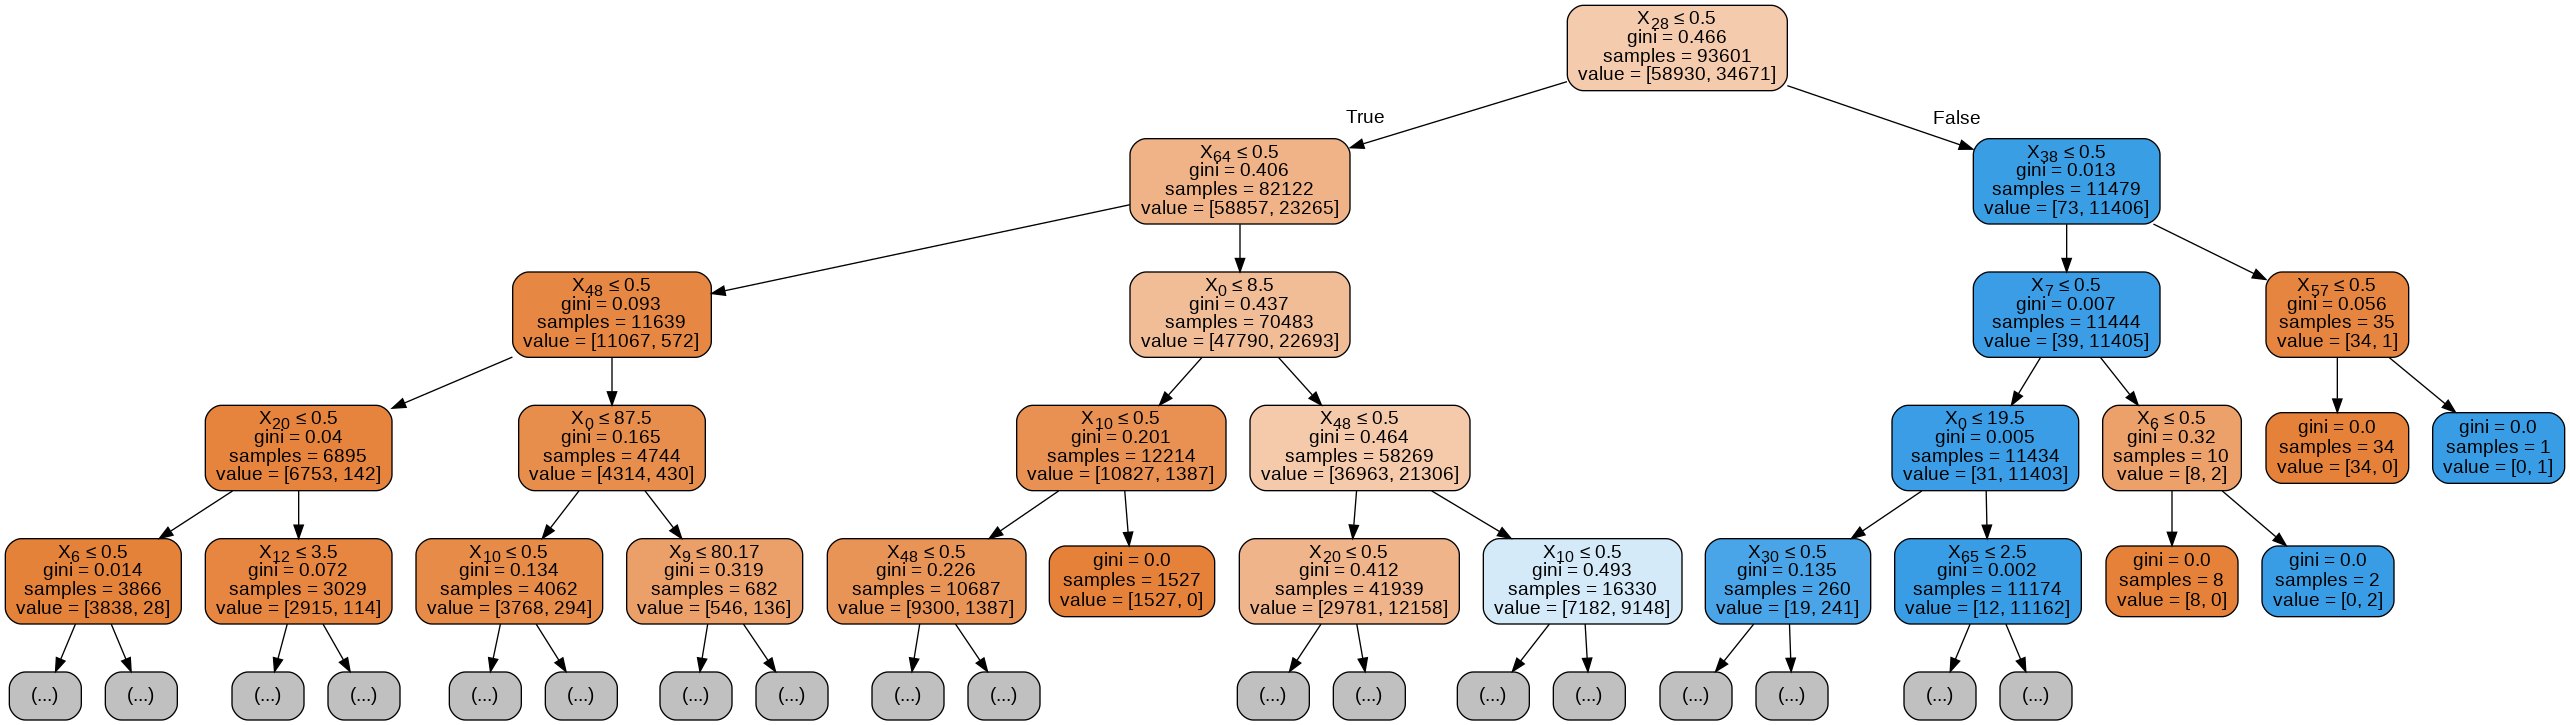

In [30]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(
    best_tree, 
    out_file=dot_data,  
    filled=True, 
    rounded=True,
    special_characters=True,
    max_depth=4
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [31]:
# Podemos pedir el árbol correspondiente ya entrenado y ver cuán importante es cada atributo
feat_imps = best_tree.feature_importances_
feat_imps

array([1.39887983e-01, 3.74103496e-02, 2.54630687e-02, 1.37612923e-02,
       5.27337147e-03, 7.89316584e-04, 1.73360915e-02, 4.03234376e-03,
       1.22711518e-03, 1.05606061e-01, 2.59932246e-02, 5.29759265e-02,
       1.02967707e-02, 8.85500798e-03, 9.99917090e-03, 3.77262618e-04,
       1.75527826e-03, 5.10730961e-03, 2.02752725e-03, 3.15459370e-03,
       6.02502079e-02, 4.48422997e-03, 1.53393908e-04, 5.28997723e-03,
       3.67882599e-03, 5.30667655e-04, 5.84552834e-04, 2.65443899e-04,
       2.35455773e-01, 7.96048336e-04, 1.17124764e-02, 6.62497198e-03,
       1.53813763e-03, 3.07114766e-03, 3.29750104e-03, 2.21035745e-03,
       2.17618483e-03, 1.31869364e-03, 6.59075112e-03, 3.53733847e-03,
       5.21890647e-03, 5.22079530e-03, 2.62023873e-03, 7.54544029e-04,
       4.53408822e-03, 2.59096364e-03, 9.55553178e-04, 1.13713561e-03,
       4.16113427e-02, 1.27270864e-03, 1.39828184e-03, 2.53385774e-03,
       5.55319356e-03, 7.28078624e-03, 4.46149827e-03, 5.22637380e-03,
      

In [32]:
# Vemos a que variables corresponden los atributos mas importantes
for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

meal_FB: 0.00015339390814410295
deposit_type_No Deposit: 0.0002654438986371264
market_segment_Complementary: 0.0003772626175881228
is_repeated_guest_0: 0.000530667655430252
is_repeated_guest_1: 0.0005845528335214542
country_ISR: 0.0007545440292775782
babies: 0.0007893165843771488
customer_type_Contract: 0.0007960483355964433
country_NOR: 0.0009555531779575387
country_POL: 0.0011371356105662942
days_in_waiting_list: 0.0012271151813366416
country_RUS: 0.0012727086399780883
country_CN: 0.0013186936366921874
country_SWE: 0.0013982818441728446
country_AUT: 0.0015381376264934651
market_segment_Corporate: 0.0017552782631517175
booker_room_gain: 0.0018328308887842982
market_segment_Groups: 0.002027527254790602
country_CHN: 0.00217618483321071
country_CHE: 0.002210357452788545
country_USA: 0.002533857737888279
country_NLD: 0.0025909636421089636
country_IRL: 0.0026202387253064967
country_BEL: 0.0030711476595221506
market_segment_Offline TA/TO: 0.0031545936966909964
country_BRA: 0.003297501036828

## i. K-fold y α de poda

### Iterando con K-Fold

In [33]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, f1_score
import numpy as np

x_train, x_val, y_train, y_val = train_test_split(
      x_dev, 
      y_dev, 
      test_size=0.2, 
      random_state=seed,
      stratify=y_dev
  ) 

# Armo un TreeClassifier para identificar los alphas efectivos de poda y las impurezas que eliminamos de sus hojas
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(x_dev,y_dev)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0, 0.5, 'total impurity of leaves')

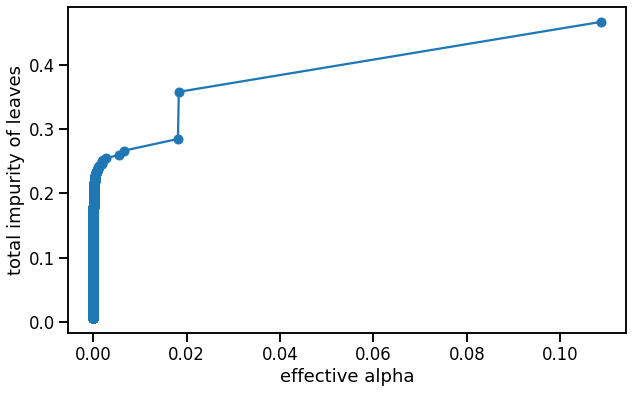

In [34]:
# Graficamos para cada alpha el total de impureza eliminado
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities, marker='o')
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

In [35]:
# Agarro algunos valores que queremos de alfa
kfold_alphas = []
for ccp_alpha, impurity in zip(ccp_alphas, impurities):
  if impurity > 0.26:
    kfold_alphas.append(ccp_alpha)

print(len(kfold_alphas))

4


In [36]:
# Entrenamos ahora los arboles usando un Stratified K-fold de 10
kfoldcv = StratifiedKFold(n_splits=10)

trained_trees = []
trained_alphas = []

for ccp_alpha in kfold_alphas:
  for train_index, test_index in kfoldcv.split(x_dev, y_dev):
    x_train, x_val = x_dev[train_index], x_dev[test_index]
    y_train, y_val = y_dev[train_index], y_dev[test_index]
    
    ccp_tree = DecisionTreeClassifier(
        ccp_alpha = ccp_alpha
    )

    ccp_tree.fit(x_train,y_train)
    
    trained_trees.append(ccp_tree)
    trained_alphas.append(ccp_alpha)
  
print(len(trained_trees)) 
print(len(trained_alphas)) 

40
40


In [37]:
tree_nodes = []
tree_depth = []
for tree in trained_trees:
  tree_nodes.append(tree.tree_.node_count)
  tree_depth.append(tree.tree_.max_depth)

tree_metrics_results = pd.DataFrame(
    {
     'alpha':trained_alphas,
     'nodes': tree_nodes,
     'depth': tree_depth
    }
)

In [38]:
tree_metrics_results.loc[tree_metrics_results['nodes'] > 1]


,alpha,nodes,depth
0,0.006615,13,6
1,0.006615,15,6
2,0.006615,13,6
3,0.006615,15,6
4,0.006615,13,6
5,0.006615,13,6
6,0.006615,15,6
7,0.006615,13,6
8,0.006615,13,6
9,0.006615,13,6


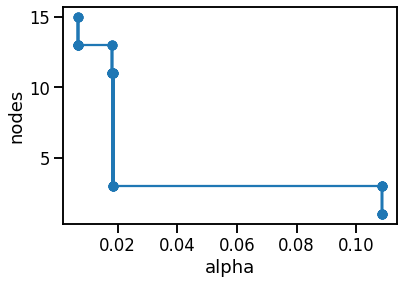

In [39]:
fig, ax = plt.subplots()
ax.plot(tree_metrics_results['alpha'], tree_metrics_results['nodes'], marker='o', drawstyle="steps-post")
ax.set_xlabel("alpha")
ax.set_ylabel("nodes")
fig.show()

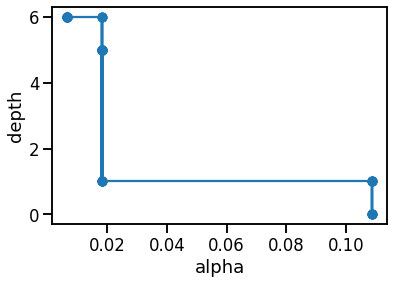

In [40]:
fig, ax = plt.subplots()
ax.plot(tree_metrics_results['alpha'], tree_metrics_results['depth'], marker='o', drawstyle="steps-post")
ax.set_xlabel("alpha")
ax.set_ylabel("depth")
fig.show()

In [41]:
# Train & Validation Metrics for alphas
# Lo medimos en F-2 Score
metrics = []
alphas = []
vals = []

best_alpha = None
best_score = None

for train_index, test_index in kfoldcv.split(x_dev, y_dev):
  x_train, x_val = x_dev[train_index], x_dev[test_index]
  y_train, y_val = y_dev[train_index], y_dev[test_index]

  for ccp_tree in trained_trees:
  
    # Ejecutamos nuestra predicción
    y_train_val = ccp_tree.predict(x_train)
    y_pred_val = ccp_tree.predict(x_val)
    
    f2_train_score = fbeta_score(y_train,y_train_val, beta=2)
    f2_val_score = fbeta_score(y_val,y_pred_val, beta=2)

    if best_score is None or best_score < f2_val_score:
      best_score = f2_val_score
      best_alpha = ccp_tree.ccp_alpha

    metrics.extend(['F2 Train Score','F2 Val Score',])
    vals.extend([f2_train_score, f2_val_score])
    alphas.extend([ccp_tree.ccp_alpha]*2)

metric_results = pd.DataFrame({'metric':metrics,'alphas':alphas,'value':vals})

print(best_score)
print(best_alpha)

0.7833064919198091
0.0066154043863585615


In [42]:
# Best alpha 1.0786538889762798e-05
# Graficar scores en entrenamiento y en validation para nuestro 10-fold

score_train_metric = metric_results.loc[metric_results['metric'] == 'F2 Train Score']
score_val_metric = metric_results.loc[metric_results['metric'] == 'F2 Val Score']


mean_train_score = score_train_metric.groupby(['alphas']).mean().reset_index()
mean_val_score = score_val_metric.groupby(['alphas']).mean().reset_index()

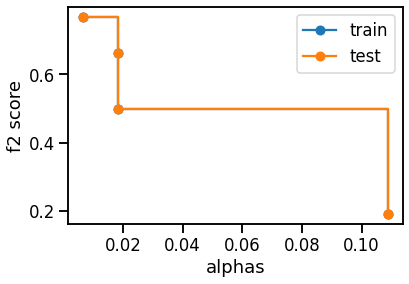

In [43]:
fig, ax = plt.subplots()
ax.set_xlabel("alphas")
ax.set_ylabel("f2 score")

ax.plot(
    mean_train_score['alphas'], 
    mean_train_score['value'], 
    marker='o', 
    label="train",
    drawstyle="steps-post"
)

ax.plot(
    mean_val_score['alphas'], 
    mean_val_score['value'], 
    marker='o', 
    label="test",
    drawstyle="steps-post"
)

ax.legend()
plt.show()

## j. Arbol con poda vs Arbol sin poda

In [44]:
import pandas as pd

ccp_alpha_tree = DecisionTreeClassifier(
    ccp_alpha = best_alpha
)

no_prune_tree = DecisionTreeClassifier(
    ccp_alpha = 0
)

ccp_alpha_tree.fit(x_dev, y_dev)
no_prune_tree.fit(x_dev, y_dev)

y_ccp_predict = ccp_alpha_tree.predict(x_test)
y_no_prune_predict = no_prune_tree.predict(x_test)

ccp_score = fbeta_score(y_test,y_ccp_predict, beta=2)
no_prune_score = fbeta_score(y_test,y_no_prune_predict, beta=2)

tree_comparison = pd.DataFrame(
    {
     'tree': ['ccp_alpha','no_prune'],
     'alpha': [best_alpha, 0],   
     'f2score': [ccp_score,no_prune_score],
     'nodes': [ccp_alpha_tree.tree_.node_count, no_prune_tree.tree_.node_count],
     'depth': [ccp_alpha_tree.tree_.max_depth, no_prune_tree.tree_.max_depth]
    }
)


In [45]:
tree_comparison

,tree,alpha,f2score,nodes,depth
0,ccp_alpha,0.006615,0.766562,13,6
1,no_prune,0.000000,0.799517,24131,53


## k. Eliminación Recursiva

In [46]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [47]:
df_correlations
list(correlaciones.loc[correlaciones['Abs(Cor)']>0.1]['Atributo'])
df_correlations2 = df_correlations.loc[:,list(correlaciones.loc[correlaciones['Abs(Cor)']>0.1]['Atributo'])]
df_correlations2 = pd.concat([df_correlations2,df_categoricas['is_canceled']],axis=1)
df_correlations2
features =  df_correlations2.loc[:, df_correlations2.columns != 'is_canceled'].columns
target = 'is_canceled'
x_dev2, x_test2, y_dev2, y_test2 = train_test_split(
    df_correlations2[features].values, 
    df_correlations2[target].values, 
    test_size=0.2, 
    random_state=42,
    stratify=df_correlations2[target].values
)                    

In [48]:
len(list(correlaciones.loc[correlaciones['Abs(Cor)']>0.1]['Atributo']))

18

In [49]:
X = x_dev2
target = y_dev2
scorer_fn = make_scorer(fbeta_score, beta=2)
rfc = RandomForestClassifier(random_state=101,max_depth=8)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(3), scoring=scorer_fn)
rfecv.fit(X, target)


RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=8, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None,
      scoring=make_scorer(fbeta_score, beta=2), step=1, verbose=0)

In [50]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 11


In [51]:
X = pd.DataFrame(x_dev2)
X.columns=df_correlations2.columns[:-1]
target = pd.DataFrame(y_dev2)
target.columns=[df_correlations2.columns[len(df_correlations2.columns)-1]]


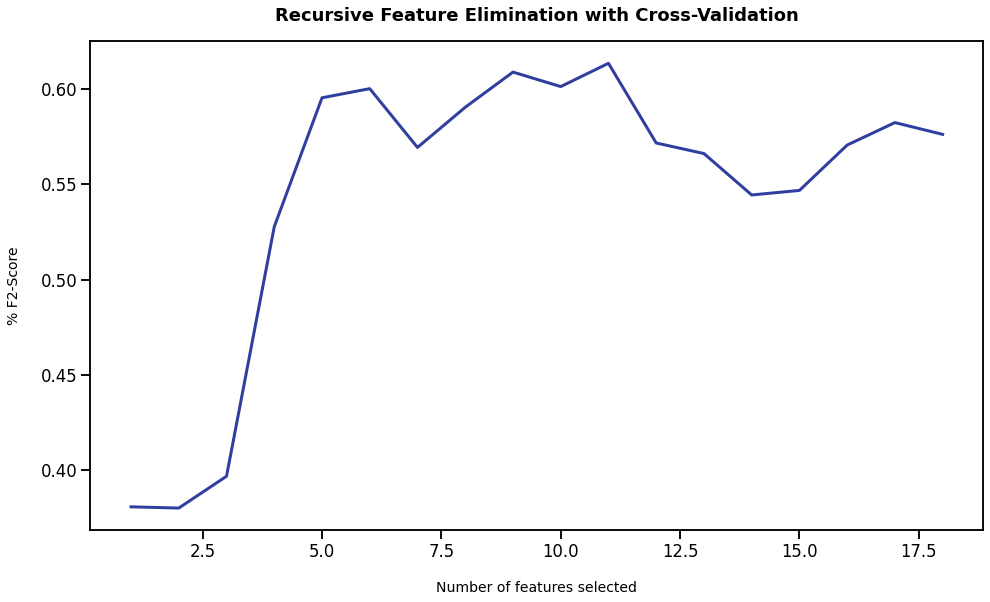

In [52]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% F2-Score', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()


In [53]:
print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)


[ 0  5  6  7 12 13 14]


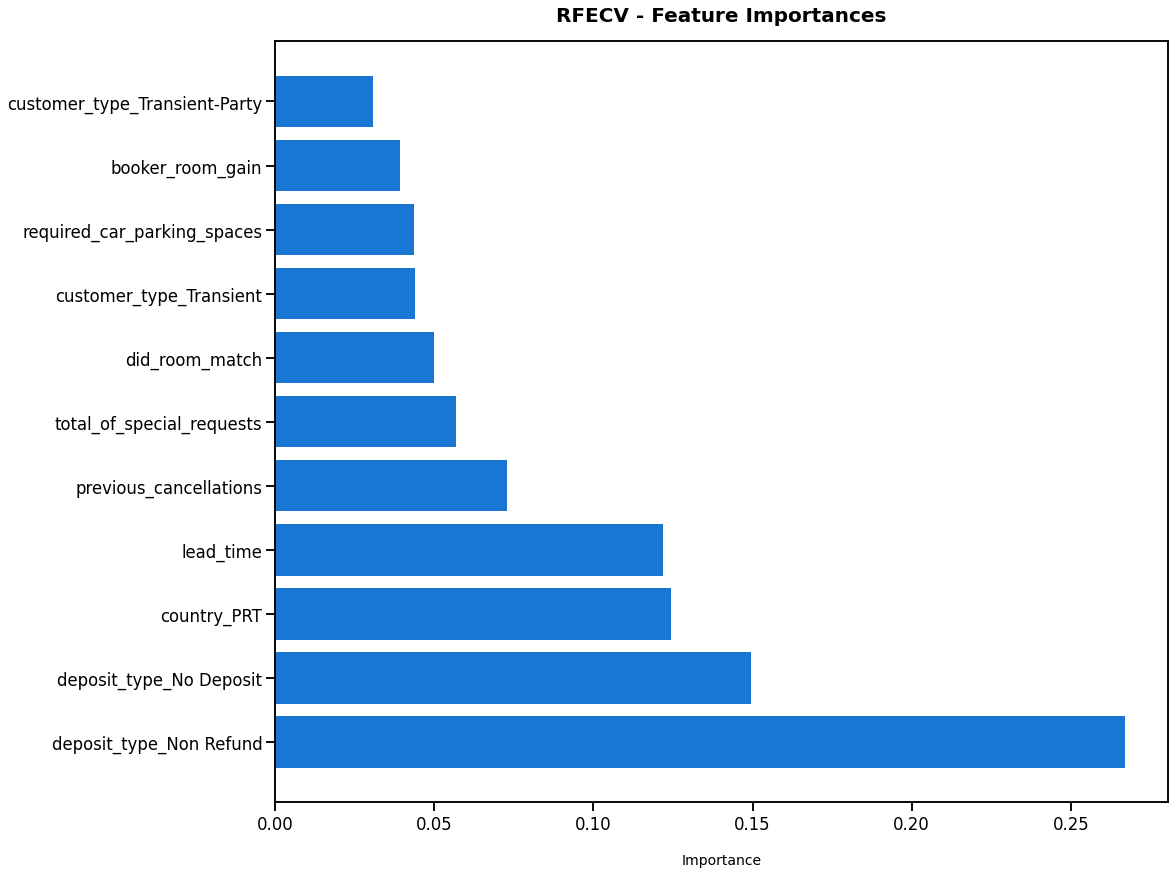

In [54]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()


In [55]:
x_dev

array([[ 20.,   2.,   0., ...,   0.,   1.,   0.],
       [  8.,   3.,   0., ...,   0.,   1.,   0.],
       [ 93.,   3.,   0., ...,   0.,   1.,   0.],
       ...,
       [135.,   3.,   0., ...,   0.,   1.,   0.],
       [172.,   5.,   2., ...,   0.,   1.,   0.],
       [223.,   5.,   1., ...,   0.,   1.,   0.]])

In [56]:
filtro=list(dset.sort_values(by='importance', ascending=False).head(4)['attr'])
df_correlations2 = df_correlations2.loc[:,filtro]
df_correlations2 = pd.concat([df_correlations2,df_categoricas['is_canceled']],axis=1)
#Le saco deposit type no deposit, por estar muy correlacionada con deposit type non refund
df_correlations2 = df_correlations2.drop(['deposit_type_No Deposit'], axis=1)
df_correlations2


,deposit_type_Non Refund,country_PRT,lead_time,is_canceled
0,0,1,342,0
1,0,1,737,0
2,0,0,7,0
3,0,0,13,0
4,0,0,14,0
...,...,...,...,...
119385,0,0,23,0
119386,0,0,102,0
119387,0,0,34,0
119388,0,0,109,0


In [57]:
features =  df_correlations2.loc[:, df_correlations2.columns != 'is_canceled'].columns
target = 'is_canceled'


arbol_corto= DecisionTreeClassifier(max_depth=3)
arbol_corto.fit(x_dev2,y_dev2)
y_pred_test2 = arbol_corto.predict(x_test2)
f2score = fbeta_score(y_test2, y_pred_test2, beta=2)
acc=accuracy_score(y_test2,y_pred_test2)
prec=precision_score(y_test2,y_pred_test2)
rec=recall_score(y_test2,y_pred_test2)
f1=f1_score(y_test2,y_pred_test2)
print(f2score,acc,prec,rec,f1)


0.3726269546571832 0.7484295167099422 0.9958071278825996 0.322215941209723 0.4868881865550525


In [60]:
df_correlations
list(correlaciones.loc[correlaciones['Abs(Cor)']>0.1]['Atributo'])
df_correlations2 = df_correlations.loc[:,list(correlaciones.loc[correlaciones['Abs(Cor)']>0.1]['Atributo'])]
df_correlations2 = pd.concat([df_correlations2,df_categoricas['is_canceled']],axis=1)
df_correlations2
features =  df_correlations2.loc[:, df_correlations2.columns != 'is_canceled'].columns
target = 'is_canceled'
x_dev2, x_test2, y_dev2, y_test2 = train_test_split(
    df_correlations2[features].values, 
    df_correlations2[target].values, 
    test_size=0.2, 
    random_state=42,
    stratify=df_correlations2[target].values
)                    

In [61]:
best_tree = None
best_score = None

for train_index, test_index in kfoldcv.split(x_dev2, y_dev2):
  x_train2, x_val2 = x_dev2[train_index], x_dev2[test_index]
  y_train2, y_val2 = y_dev2[train_index], y_dev2[test_index]

  # Tree Classifier
  kfold_tree = DecisionTreeClassifier(max_depth=3)

  # Entrenamos al arbol
  kfold_tree.fit(x_train2,y_train2)

  # Ejecutamos nuestra predicción
  y_pred_val2 = kfold_tree.predict(x_val2)

  f2score = fbeta_score(y_val2, y_pred_val2, beta=2)

  if best_score is None or best_score < f2score:
    best_score = f2score
    best_tree = kfold_tree
    
y_pred_test2 = best_tree.predict(x_test2)
f2score = fbeta_score(y_test2, y_pred_test2, beta=2)
acc=accuracy_score(y_test2,y_pred_test2)
prec=precision_score(y_test2,y_pred_test2)
rec=recall_score(y_test2,y_pred_test2)
f1=f1_score(y_test2,y_pred_test2)
print(f2score,acc,prec,rec,f1)

0.3726269546571832 0.7484295167099422 0.9958071278825996 0.322215941209723 0.4868881865550525


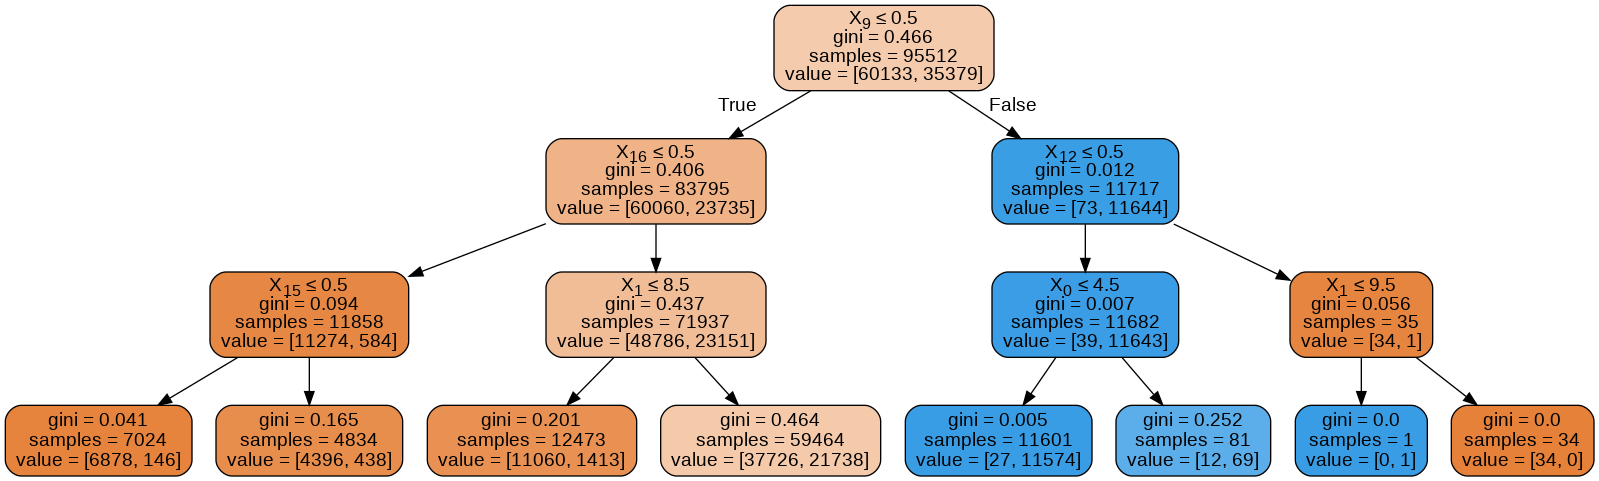

In [62]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(
    arbol_corto, 
    out_file=dot_data,  
    filled=True, 
    rounded=True,
    special_characters=True
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())



# TODO Revisar Antes


### Tunning de hiperparámetros

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import numpy as np


# Parameter tuning extracted from
# https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
top_range = len(df_correlations.columns)

params_grid = {'criterion':['gini','entropy'],
               'splitter': ['best', 'random'],
               'min_samples_leaf': list(range(1,20)),
               'max_features': ['sqrt','log2'],
               'max_depth':list(range(1,top_range)),
              }

# Nuestra función de scoring es f2 score porque queremos que nuestro algoritmo 
# contemple tanto la precisión como el recall (dandole mas peso a este ultimo)
scorer_fn = make_scorer(fbeta_score, beta=2)

kfoldcv = StratifiedKFold(n_splits=50)

base_tree = DecisionTreeClassifier()
randomcv = RandomizedSearchCV(
    estimator=base_tree,
    param_distributions = params_grid,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter = 50,
    random_state = 50
)
randomcv.fit(x_dev,y_dev);

In [ ]:
# Guardamos los resultados de K-Fold 
kfold_results = pd.DataFrame(randomcv.cv_results_)

kfold_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.110819,0.008285,0.013118,0.000201,best,8,log2,8,entropy,"{'splitter': 'best', 'min_samples_leaf': 8, 'm...",0.443156,0.656521,0.565921,0.493297,0.650815,0.561942,0.084477,44
1,0.133810,0.011917,0.014475,0.000154,random,11,sqrt,17,entropy,"{'splitter': 'random', 'min_samples_leaf': 11,...",0.625074,0.652889,0.654883,0.657363,0.656368,0.649315,0.012214,39
2,0.193676,0.015484,0.016584,0.000145,best,2,log2,44,entropy,"{'splitter': 'best', 'min_samples_leaf': 2, 'm...",0.732724,0.750481,0.746664,0.750922,0.732980,0.742754,0.008220,7
3,0.145112,0.008198,0.014758,0.000412,best,11,log2,16,entropy,"{'splitter': 'best', 'min_samples_leaf': 11, '...",0.702465,0.718470,0.695505,0.694440,0.656010,0.693378,0.020563,28
4,0.160607,0.005946,0.015656,0.000296,best,9,log2,43,entropy,"{'splitter': 'best', 'min_samples_leaf': 9, 'm...",0.737698,0.717535,0.733270,0.723755,0.712401,0.724932,0.009441,16


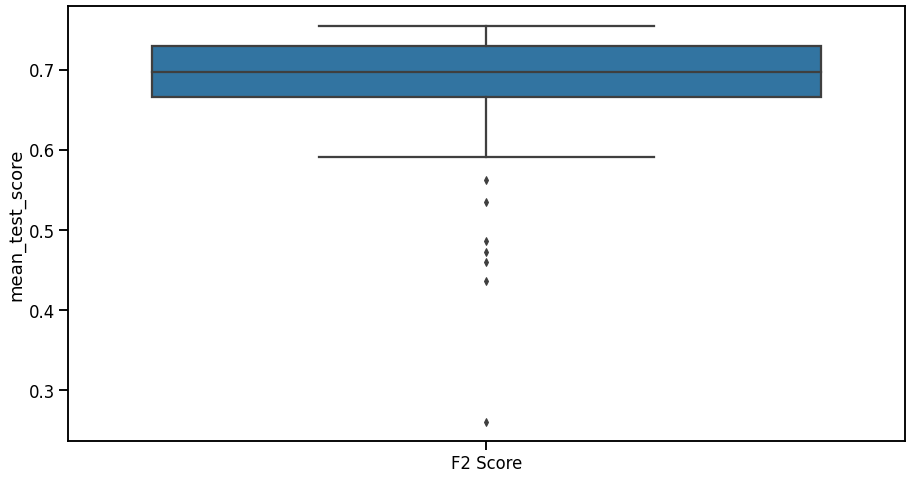

In [ ]:
# Boxplots de f2 score en 50-fold cross validation
f2score_metric = kfold_results['mean_test_score']
f2score_label = ['F2 Score']*len(f2score_metric)

sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(f2score_label,f2score_metric)

In [ ]:
randomcv.best_params_

{'criterion': 'entropy',
 'max_depth': 65,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'splitter': 'best'}

Corrimos nuestro análisis de K-Fold, para optimizar hiperparámetros utilizando dos criterios de scoring y obteniendo los siguientes resultados:

*   fbeta2 scorer:
```
{
 'criterion': 'entropy',
 'max_depth': 65,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'splitter': 'best'
}
```



## i. K-fold y α de poda

In [ ]:
x_train_sets = []
x_val_sets = []
y_train_sets = []
y_val_sets = []

# Armo mis splits train-val
for index in range(10):
  x_train, x_val, y_train, y_val = train_test_split(
        x_dev, 
        y_dev, 
        test_size=0.2, 
        random_state=seed,
        stratify=y_dev
    )
  x_train_sets.append(x_train)
  x_val_sets.append(x_val)
  y_train_sets.append(y_train)
  y_val_sets.append(y_val)

# Tree Classifier
ccp_tree = DecisionTreeClassifier(
    criterion='entropy',
    splitter = 'best',
    max_features =  'sqrt',
    max_depth=65,
    min_samples_leaf=2
)

# Calculos los 
ccp_path = ccp_tree.cost_complexity_pruning_path(x_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
# Vamos a podar nuestra arbol mejor clasificado
clf = randomcv.best_estimator_
path = clf.cost_complexity_pruning_path(x_train,y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import numpy as np

params_grid = {'ccp_alpha':filtered}
scorer_fn = make_scorer(fbeta_score, beta=2)

kfoldcv = StratifiedKFold(n_splits=10)

base_tree = DecisionTreeClassifier(
    random_state=0, 
    criterion = 'entropy',
    max_depth = 28 
)

randomcv = RandomizedSearchCV(
    estimator = base_tree,
    param_distributions = params_grid,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter = 10,
    random_state = 50
)
randomcv.fit(x_train,y_train);

## Analizamos metricas K-Fold


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

best_model = randomcv.best_estimator_
y_pred = best_model.predict(x_test)

print(
    classification_report(y_test,y_pred)
)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     15033
           1       0.79      0.80      0.80      8845

    accuracy                           0.85     23878
   macro avg       0.84      0.84      0.84     23878
weighted avg       0.85      0.85      0.85     23878



Text(19.5, 0.5, 'True')

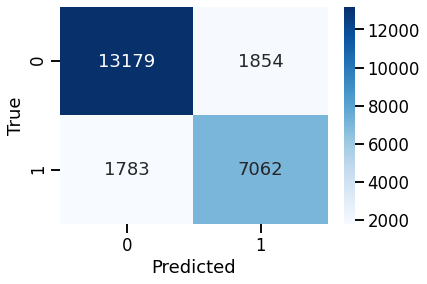

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


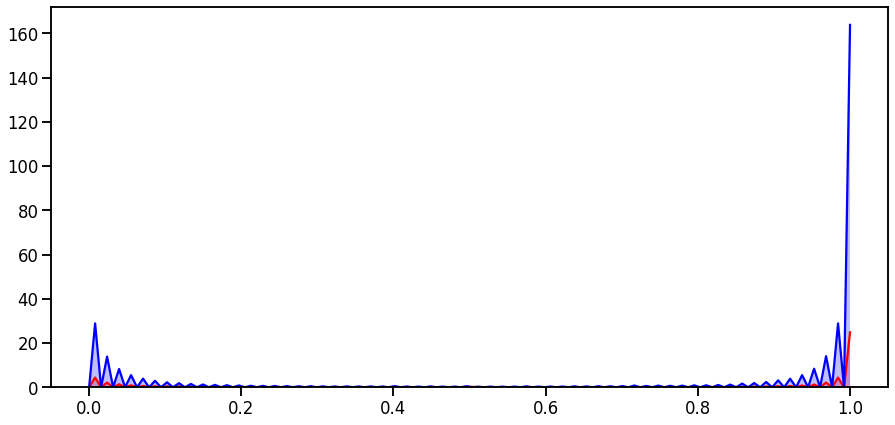

In [ ]:
y_scores = best_model.predict_proba(x_test)
out_probs = y_scores[:,1]

plt.figure(figsize=(15,7))
sns.kdeplot(out_probs[y_test==0],shade=True,c='r')
sns.kdeplot(out_probs[y_test==1],shade=True,c='b')

## g. Poda de Arbol

In [ ]:
# Vamos a podar nuestra arbol mejor clasificado
clf = randomcv.best_estimator_
path = clf.cost_complexity_pruning_path(x_train,y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
ccp_alphas


array([0.        , 0.        , 0.        , ..., 0.01812787, 0.01831502,
       0.10866758])

In [ ]:
impurities

array([0.00930319, 0.00930319, 0.00930319, ..., 0.28448736, 0.35774746,
       0.46641504])

Text(0, 0.5, 'total impurity of leaves')

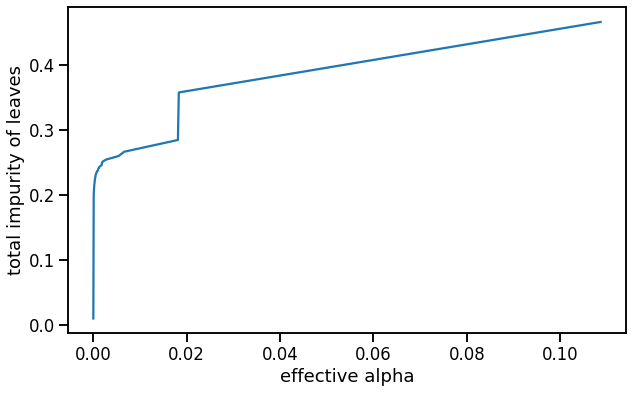

In [ ]:
# Graficamos el cost complexity pruning path de nuestro arbol
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

In [ ]:
filter_arr = []

# go through each element in arr
for element in impurities:
  # if the element is completely divisble by 2, set the value to True, otherwise False
  if element > 0.24:
    filter_arr.append(True)
  else:
    filter_arr.append(False)


filtered = ccp_alphas[filter_arr]
print(len(filtered))

14


## i. Alpha K-Fold Validation 

## g0. Ajuste de cantidad de atributos seleccionados

In [ ]:
len(list(correlaciones.loc[correlaciones['Abs(Cor)']>0.2]['Atributo']))

8

Para acelearar el procesamiento, reduciendo cantidad de atributos, filtrando por un valor de correlación

In [ ]:
df_correlations
list(correlaciones.loc[correlaciones['Abs(Cor)']>0.2]['Atributo'])
df_correlations = df_correlations.loc[:,list(correlaciones.loc[correlaciones['Abs(Cor)']>0.2]['Atributo'])]
df_correlations = pd.concat([df_correlations,df_categoricas['is_canceled']],axis=1)
df_correlations

,lead_time,total_of_special_requests,market_segment_Groups,deposit_type_No Deposit,deposit_type_Non Refund,country_PRT,did_room_match,booker_room_gain,is_canceled
0,342,0,0,1,0,1,1,0,0
1,737,0,0,1,0,1,1,0,0
2,7,0,0,1,0,0,0,2,0
3,13,0,0,1,0,0,1,0,0
4,14,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
119385,23,0,0,1,0,0,1,0,0
119386,102,2,0,1,0,0,1,0,0
119387,34,4,0,1,0,0,1,0,0
119388,109,0,0,1,0,0,1,0,0


In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import numpy as np

params_grid = {'ccp_alpha':filtered}

kfoldcv = StratifiedKFold(n_splits=10)
base_tree = DecisionTreeClassifier(
    random_state=0, 
    criterion = 'entropy',
    max_depth = 28 
)
scorer_fn = make_scorer(fbeta_score, beta=2)
randomcv = RandomizedSearchCV(
    estimator = base_tree,
    param_distributions = params_grid,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter = 10,
    random_state = 50
)
randomcv.fit(x_train,y_train);

In [ ]:
# Guardamos los resultados de K-Fold 
prune_kfold = pd.DataFrame(randomcv.cv_results_)
print(len(prune_kfold))
prune_kfold

10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.240388,0.015923,0.006755,0.000112,0.018315,{'ccp_alpha': 0.018315023990871926},0.774068,0.766059,0.778528,0.775358,0.774683,0.781658,0.766397,0.778741,0.772102,0.784570,0.775216,0.005704,1
1,1.234455,0.018214,0.006761,0.000144,0.0066154,{'ccp_alpha': 0.0066154043863585615},0.774068,0.766059,0.778528,0.775358,0.774683,0.781658,0.766397,0.778741,0.772102,0.784570,0.775216,0.005704,1
2,1.260067,0.024903,0.006806,0.000104,0.00542059,{'ccp_alpha': 0.005420585620468585},0.774068,0.766059,0.778528,0.775358,0.774683,0.781658,0.766397,0.778741,0.772102,0.784570,0.775216,0.005704,1
3,1.253161,0.006653,0.006858,0.000177,0.00146567,{'ccp_alpha': 0.0014656697042258887},0.772801,0.724592,0.777057,0.717153,0.747241,0.739271,0.689858,0.713457,0.769729,0.772344,0.742350,0.028905,5
4,1.242069,0.023379,0.006795,0.000133,0.00121746,{'ccp_alpha': 0.0012174582100064474},0.729660,0.726565,0.727473,0.739949,0.738630,0.740986,0.717980,0.729780,0.732172,0.724911,0.730810,0.006936,6
5,1.234883,0.024768,0.006734,0.000105,0.00209293,{'ccp_alpha': 0.002092927966462592},0.697335,0.695711,0.701369,0.702063,0.707498,0.711039,0.688614,0.698585,0.702057,0.698396,0.700267,0.005894,10
6,1.218990,0.016125,0.006716,0.000100,0.00275969,{'ccp_alpha': 0.002759690931199786},0.773484,0.764650,0.778966,0.776103,0.773773,0.783411,0.767422,0.699305,0.771293,0.784215,0.767262,0.023422,4
7,1.230827,0.017612,0.006801,0.000282,0.00181693,{'ccp_alpha': 0.0018169274904004107},0.711052,0.711967,0.714286,0.717153,0.723407,0.725191,0.704475,0.713457,0.716068,0.711167,0.714822,0.005772,7
8,1.254244,0.009580,0.006748,0.000122,0.00184403,{'ccp_alpha': 0.001844032657149039},0.711052,0.711967,0.714286,0.702063,0.723407,0.725191,0.688178,0.713457,0.716068,0.711167,0.711683,0.009974,9
9,1.258240,0.009360,0.007014,0.000798,0.00180023,{'ccp_alpha': 0.0018002286773838583},0.711052,0.711967,0.714286,0.717153,0.723407,0.725191,0.704475,0.713457,0.716068,0.711167,0.714822,0.005772,7


In [ ]:
for clf in :


SyntaxError: ignored

In [ ]:
randomcv.best_params_

In [ ]:
filtered

In [ ]:
# Vamos a buscar el valor óptimo de alpha para nuestro arbol
clfs = []

for ccp_alpha in filtered:
    clf = DecisionTreeClassifier(
        random_state=0, 
        ccp_alpha=ccp_alpha,
        criterion = 'entropy',
        max_depth = 28
    )
    clf.fit(x_train, y_train)
    clfs.append(clf)

In [ ]:
# Graficamos la relación entre alpha y la profundidad de nuestro arbol

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(filtered[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")

In [ ]:
# Graficamos el alpha que mejora nuestro fbeta score
from sklearn.metrics import fbeta_score

fbeta2_scores = [fbeta_score(y_test, clf.predict(x_test), beta=2) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(filtered[:-1], fbeta2_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("FBeta2 scores")

### Usando RandomizeSearchCV

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import numpy as np

params_grid = {'ccp_alpha':ccp_alphas}

scorer_fn = make_scorer(fbeta_score, beta=2)
kfoldcv = StratifiedKFold(n_splits=10)
ccp_tree = DecisionTreeClassifier()

randomcv = RandomizedSearchCV(
    estimator=ccp_tree,
    param_distributions = params_grid,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter = 100
)

randomcv.fit(x_dev,y_dev);